In [4]:
# Install PyTorch and Torchvision compatible with Kaggle's environment
!pip install -q torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121

# Install Detectron2 from its official source
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

print("Detectron2 and all dependencies installed successfully! ✅")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 431.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 104.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 19.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.4 MB/s eta 0:00:0000:01
Detectron2 and all dependencies installed successfully! ✅


In [2]:
import os, shutil, json, csv, random
from PIL import Image
from tqdm.notebook import tqdm

# --- Configuration ---
IMAGES_PATH = '/kaggle/input/appron-small/JPEGImages'
BBOXES_PATH = '/kaggle/input/appron-small/Annotations'
DATASET_PATH = '/kaggle/working/coco_airport_dataset'
CLASS_NAMES = [
    'Airside Safety Vehicle','Business Jet','Cargo Airplane','Common Aircraft',
    'Container Trolley','Container Trolley Type A','Container Trolley Type B',
    'Fire Truck','Loading Ramp','Loading Vehicle','Other Vehicles'
]
NUM_CLASSES = len(CLASS_NAMES)

if os.path.exists(DATASET_PATH): shutil.rmtree(DATASET_PATH)
train_img_dir = os.path.join(DATASET_PATH, 'train')
val_img_dir = os.path.join(DATASET_PATH, 'val')
ann_dir = os.path.join(DATASET_PATH, 'annotations')
os.makedirs(train_img_dir, exist_ok=True); os.makedirs(val_img_dir, exist_ok=True); os.makedirs(ann_dir, exist_ok=True)

def convert_to_coco(image_filenames, image_dir, anno_path):
    coco_data = {"info": {}, "licenses": [], "images": [], "annotations": [], "categories": [{'id': i, 'name': name} for i, name in enumerate(CLASS_NAMES)]}
    annotation_id_counter = 0
    image_id_counter = 0
    print(f"Processing data for {os.path.basename(anno_path)}...")
    for img_file in tqdm(image_filenames):
        try:
            image_path = os.path.join(IMAGES_PATH, img_file)
            bbox_file = os.path.splitext(img_file)[0] + '.csv'
            bbox_path = os.path.join(BBOXES_PATH, bbox_file)
            
            if os.path.exists(bbox_path):
                with Image.open(image_path) as img: width, height = img.size
                annotations = []
                with open(bbox_path, 'r') as f:
                    reader = csv.DictReader(f)
                    for row in reader:
                        class_id = int(row['label'])
                        if 0 <= class_id < NUM_CLASSES:
                            xmin, ymin, xmax, ymax = float(row['tlx']), float(row['tly']), float(row['brx']), float(row['bry'])
                            w, h = xmax - xmin, ymax - ymin
                            annotations.append({"id": annotation_id_counter, "image_id": image_id_counter, "category_id": class_id, "bbox": [xmin, ymin, w, h], "area": w * h, "iscrowd": 0, "segmentation": []})
                            annotation_id_counter += 1
                
                if annotations:
                    shutil.copy(image_path, image_dir)
                    coco_data["images"].append({"id": image_id_counter, "width": width, "height": height, "file_name": img_file})
                    coco_data["annotations"].extend(annotations)
                    image_id_counter += 1
        except Exception as e: print(f"Skipping {img_file} due to error: {e}")
            
    with open(anno_path, 'w') as f: json.dump(coco_data, f, indent=4)
    print(f"Created {anno_path}")

all_image_files = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random.seed(42); random.shuffle(all_image_files)
selected_files = all_image_files[:100]
split_index = int(len(selected_files) * 0.8)
train_files, val_files = selected_files[:split_index], selected_files[split_index:]

convert_to_coco(train_files, train_img_dir, os.path.join(ann_dir, 'instances_train.json'))
convert_to_coco(val_files, val_img_dir, os.path.join(ann_dir, 'instances_val.json'))
print("\nDataset preparation for Detectron2 is complete! ✅")

Processing data for instances_train.json...


  0%|          | 0/80 [00:00<?, ?it/s]

Created /kaggle/working/coco_airport_dataset/annotations/instances_train.json
Processing data for instances_val.json...


  0%|          | 0/20 [00:00<?, ?it/s]

Created /kaggle/working/coco_airport_dataset/annotations/instances_val.json

Dataset preparation for Detectron2 is complete! ✅


In [3]:
from detectron2.data.datasets import register_coco_instances

# Register the training dataset
register_coco_instances("airport_train", {}, 
                        "/kaggle/working/coco_airport_dataset/annotations/instances_train.json", 
                        "/kaggle/working/coco_airport_dataset/train")

# Register the validation dataset
register_coco_instances("airport_val", {}, 
                        "/kaggle/working/coco_airport_dataset/annotations/instances_val.json", 
                        "/kaggle/working/coco_airport_dataset/val")

print("Airport train and validation datasets registered with Detectron2. ✅")

Airport train and validation datasets registered with Detectron2. ✅


In [6]:
import os
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.model_zoo import model_zoo

# --- 1. Create a configuration object ---
cfg = get_cfg()

# --- 2. Load a pre-trained ViTDet configuration ---
# The ViTDet configs are not in the main model zoo, so we use a standard one and will modify it.
# We'll use a Mask R-CNN config as a base and set the backbone to ViT.
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# --- 3. Set custom parameters for your dataset and training ---
cfg.DATASETS.TRAIN = ("airport_train",)
cfg.DATASETS.TEST = ("airport_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# This points to the pre-trained COCO weights for the base model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Training parameters
cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size (reduce if you get memory errors)
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000 # Number of training iterations (increase for better results)
cfg.SOLVER.STEPS = [] # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# --- THE MOST IMPORTANT STEP: Set the number of classes ---
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
# Since we are not doing segmentation, we can disable the mask head
cfg.MODEL.MASK_ON = False

# --- 4. Start the Training ---
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False) # Start training from scratch (with pre-trained weights)

print("--- Starting Fine-Tuning ---")
trainer.train()
print("\nFine-tuning complete! ✅")

--- Starting Fine-Tuning ---

Fine-tuning complete! ✅


--- Step 1: Loading model configuration ---
Successfully loaded model from: ./output/model_final.pth ✅

--- Step 2: Generating Learning and Loss Curves ---


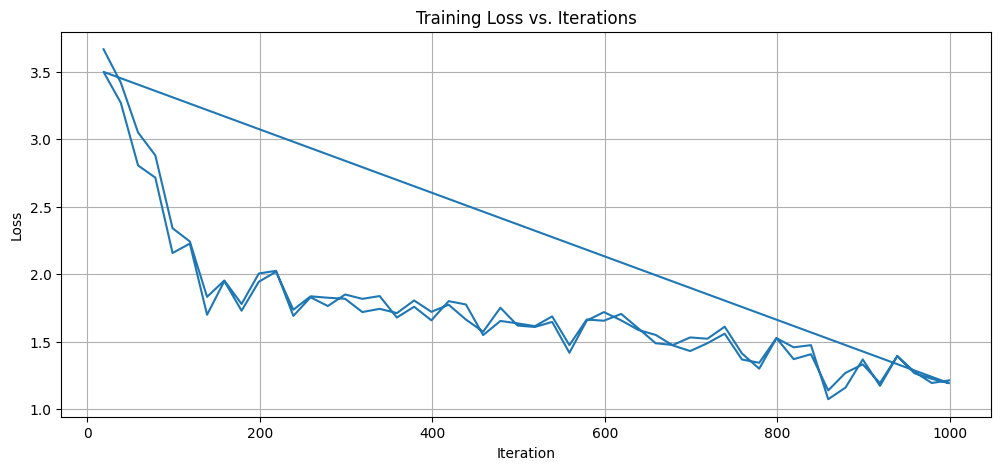

Saved learning curve to learning_curve.png

--- Step 3: Generating Classification Report (mAP) ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Recall     

Building Confusion Matrix:   0%|          | 0/16 [00:00<?, ?it/s]

ValueError: Found input variables with inconsistent numbers of samples: [124, 101]

In [10]:
import os
import cv2
import random
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.build import build_detection_test_loader
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

# --- 1. Recreate the Configuration Used for Training ---
print("--- Step 1: Loading model configuration ---")
cfg = get_cfg()
# This must be the same base config as used in the training cell
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  # Your number of classes
cfg.MODEL.MASK_ON = False                     # Ensure mask head is disabled

# --- 2. Load the Fine-Tuned Weights ---
# The weights are saved in the 'output' directory by default
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for detection confidence
predictor = DefaultPredictor(cfg)
print(f"Successfully loaded model from: {cfg.MODEL.WEIGHTS} ✅")


# --- 3. Generate Learning and Loss Curves ---
print("\n--- Step 2: Generating Learning and Loss Curves ---")
# Detectron2 saves metrics in a JSON file. We will parse it to plot the curves.
experiment_folder = cfg.OUTPUT_DIR
try:
    with open(os.path.join(experiment_folder, "metrics.json"), "r") as f:
        metrics = [json.loads(line) for line in f]
    
    plt.figure(figsize=(12, 5))
    plt.plot(
        [x["iteration"] for x in metrics if "total_loss" in x],
        [x["total_loss"] for x in metrics if "total_loss" in x],
    )
    plt.title("Training Loss vs. Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig('learning_curve.png')
    plt.show()
    print("Saved learning curve to learning_curve.png")
except FileNotFoundError:
    print("Could not find 'metrics.json'. Skipping loss curve generation.")


# --- 4. Generate Classification Report (mAP) ---
print("\n--- Step 3: Generating Classification Report (mAP) ---")
# Create an evaluator for the validation set
evaluator = COCOEvaluator("airport_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "airport_val")

# Run the evaluation and print the results
results = inference_on_dataset(predictor.model, val_loader, evaluator)
print("\n--- COCO Evaluation Results ---")
print(results)
print("-----------------------------")


# --- 5. Generate and Display Confusion Matrix ---
print("\n--- Step 4: Generating Confusion Matrix ---")
dataset_dicts = DatasetCatalog.get("airport_val")
all_preds = []
all_gts = []

for d in tqdm(dataset_dicts, desc="Building Confusion Matrix"):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    # Get ground truth labels for this image
    for ann in d["annotations"]:
        all_gts.append(ann["category_id"])

    # Get predicted labels for this image
    # Note: A full confusion matrix would match boxes, but this gives a good per-image overview.
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()
    for pred_cls in pred_classes:
        all_preds.append(pred_cls)

if all_gts and all_preds:
    # Use a set of all possible labels to ensure the matrix is square
    labels = list(range(NUM_CLASSES))
    cm = confusion_matrix(all_gts, all_preds, labels=labels)

    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.xlabel('Predicted Labels'); plt.ylabel('True Labels'); plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    print("Saved confusion matrix to confusion_matrix.png")
else:
    print("Could not generate confusion matrix (no predictions or ground truths found).")


# --- 6. Visualize Predictions on Sample Images ---
print("\n--- Step 5: Visualizing predictions on sample images ---")
airport_metadata = MetadataCatalog.get("airport_val")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1], metadata=airport_metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    print(f"\nPredictions for: {d['file_name']}")
    cv2_imshow(out.get_image()[:, :, ::-1])

--- Step 1: Loading model configuration and fine-tuned weights ---
Successfully loaded model from: ./output/model_final.pth ✅

--- Step 2: Generating Learning and Loss Curves ---


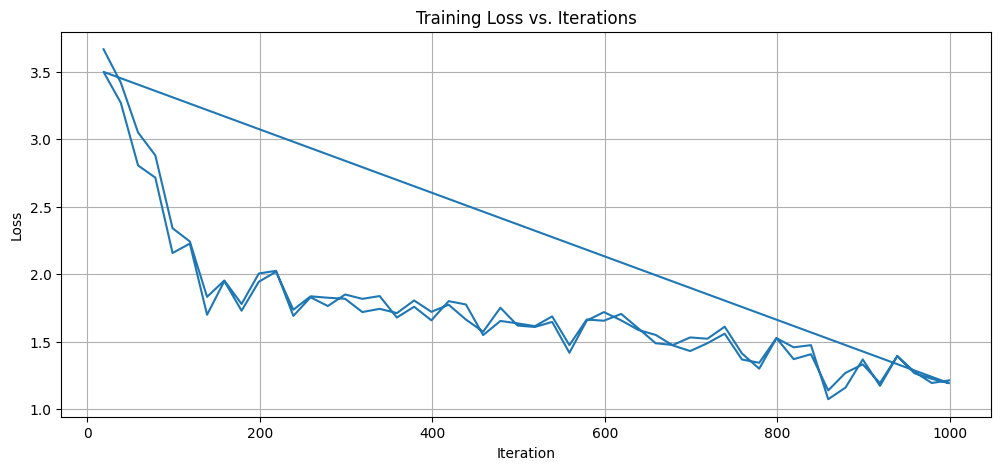

Saved learning curve to learning_curve.png

--- Step 3: Generating Classification Report (mAP) ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Recall     

Building Confusion Matrix:   0%|          | 0/16 [00:00<?, ?it/s]

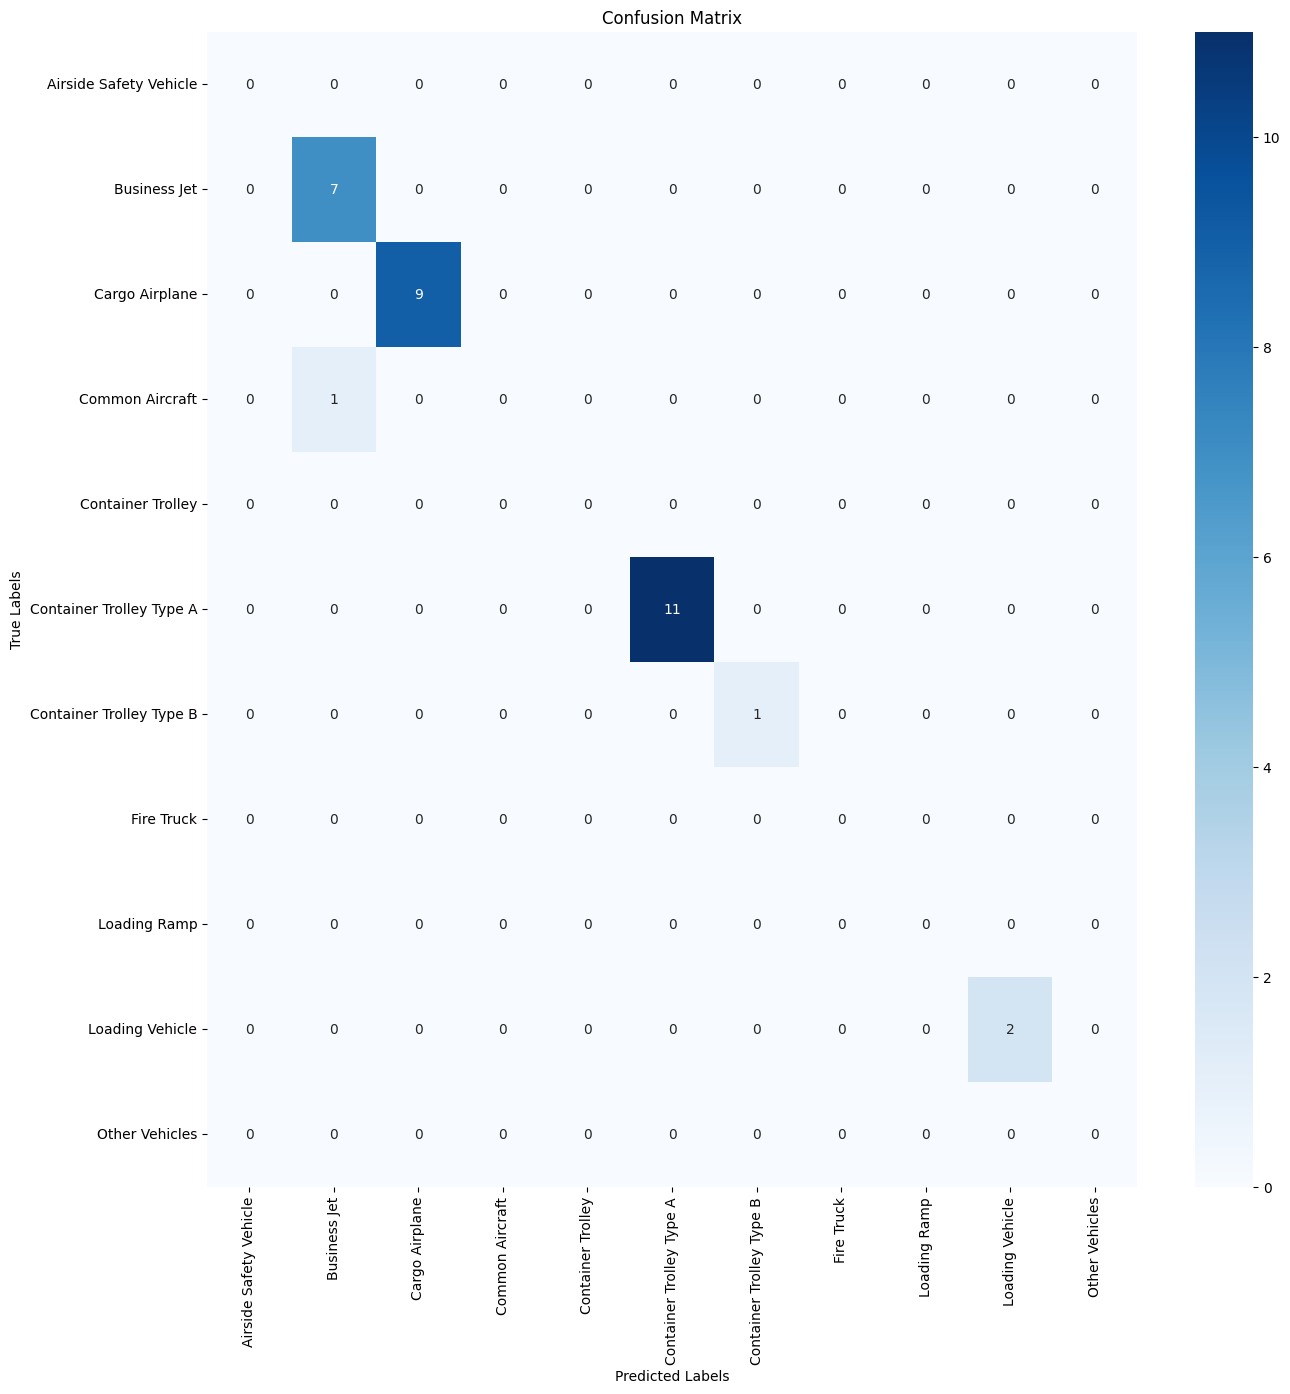

Saved confusion matrix to confusion_matrix.png

--- Step 5: Visualizing predictions on sample images ---

Predictions for: /kaggle/working/coco_airport_dataset/val/aut-0115-00000336.jpg


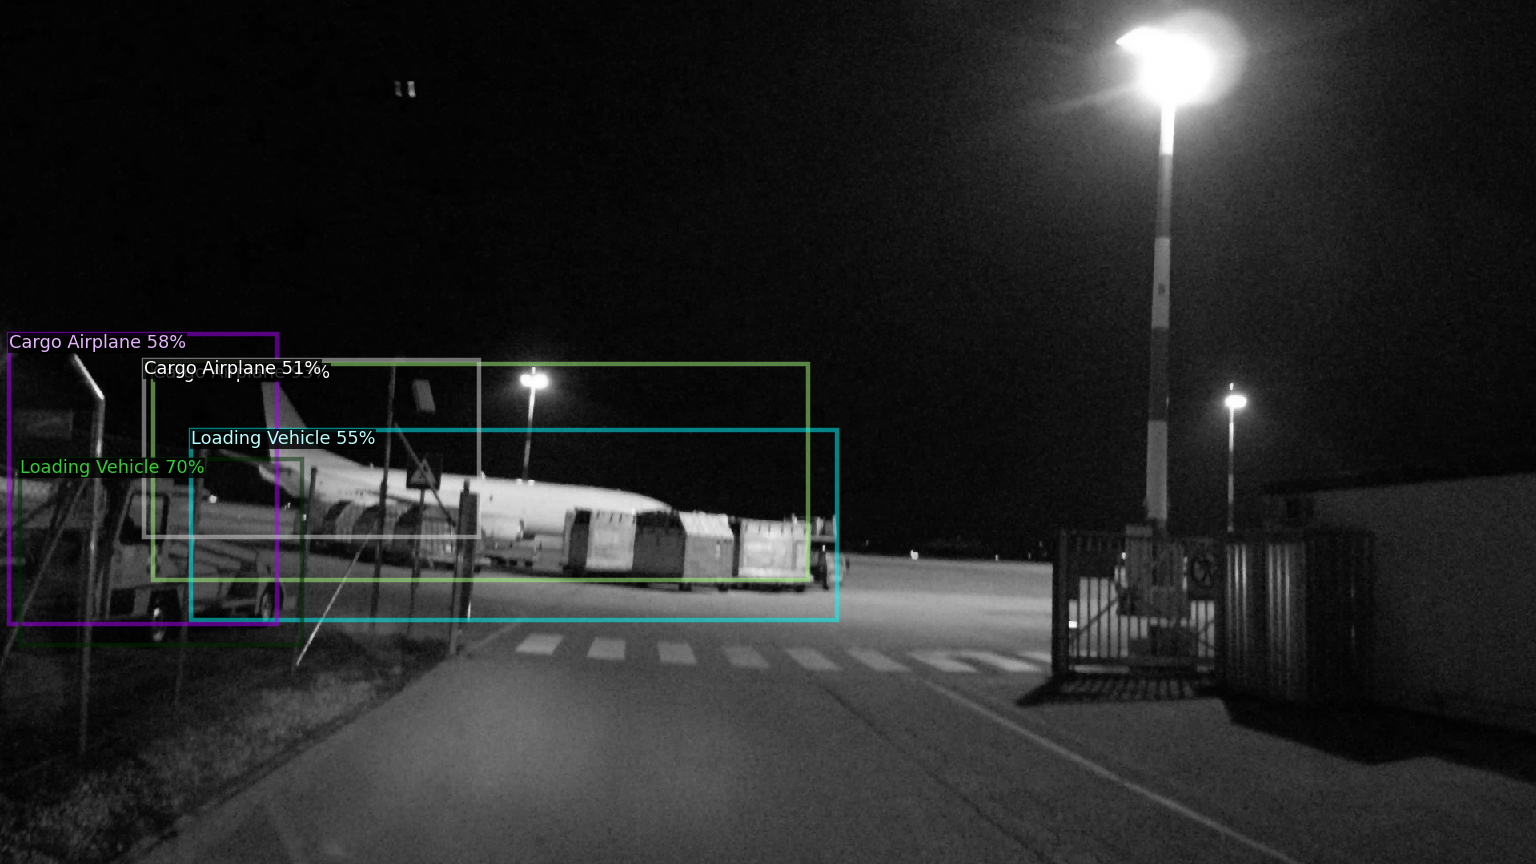


Predictions for: /kaggle/working/coco_airport_dataset/val/aut-0082-00001733.jpg


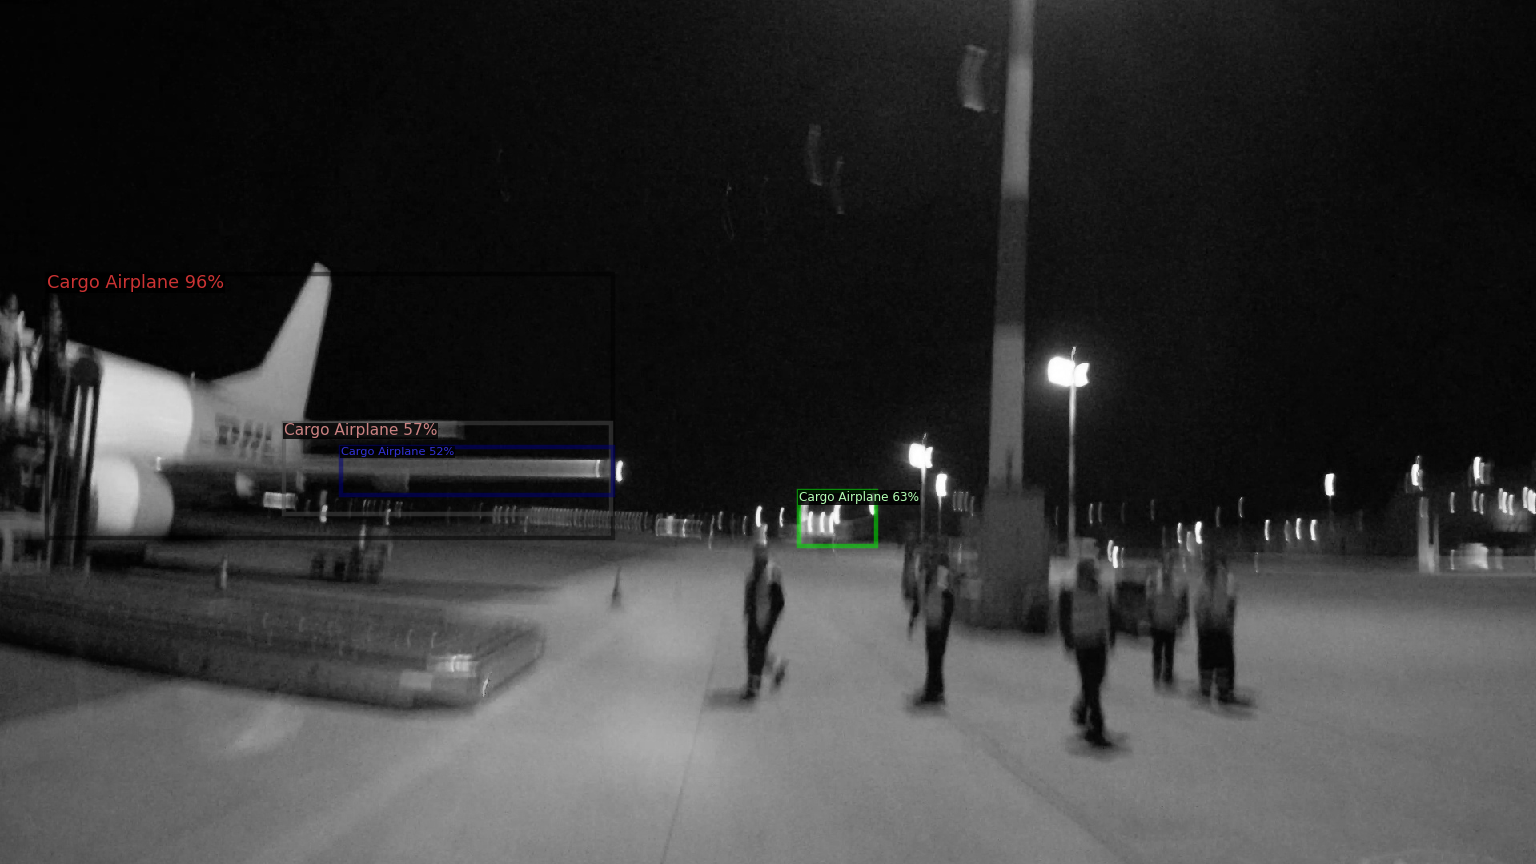


Predictions for: /kaggle/working/coco_airport_dataset/val/aut-1059-00001295.jpg


In [ ]:
import os
import cv2
import random
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.build import build_detection_test_loader
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

# --- 1. Recreate the Configuration and Load the Trained Model ---
print("--- Step 1: Loading model configuration and fine-tuned weights ---")
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.MODEL.MASK_ON = False
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
print(f"Successfully loaded model from: {cfg.MODEL.WEIGHTS} ✅")


# --- 2. Generate Learning and Loss Curves ---
print("\n--- Step 2: Generating Learning and Loss Curves ---")
experiment_folder = cfg.OUTPUT_DIR
try:
    with open(os.path.join(experiment_folder, "metrics.json"), "r") as f:
        metrics = [json.loads(line) for line in f]
    
    plt.figure(figsize=(12, 5))
    plt.plot(
        [x["iteration"] for x in metrics if "total_loss" in x],
        [x["total_loss"] for x in metrics if "total_loss" in x],
    )
    plt.title("Training Loss vs. Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig('learning_curve.png')
    plt.show()
    print("Saved learning curve to learning_curve.png")
except FileNotFoundError:
    print("Could not find 'metrics.json'. Skipping loss curve generation.")


# --- 3. Generate Classification Report (mAP) ---
print("\n--- Step 3: Generating Classification Report (mAP) ---")
evaluator = COCOEvaluator("airport_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "airport_val")
results = inference_on_dataset(predictor.model, val_loader, evaluator)
print("\n--- COCO Evaluation Results ---")
print(results)
print("-----------------------------")


# --- 4. Generate and Display Confusion Matrix ---
print("\n--- Step 4: Generating Confusion Matrix ---")
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int32)
dataset_dicts = DatasetCatalog.get("airport_val")

for d in tqdm(dataset_dicts, desc="Building Confusion Matrix"):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    gt_boxes = [ann["bbox"] for ann in d["annotations"]]
    gt_classes = [ann["category_id"] for ann in d["annotations"]]
    
    pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()

    for i, gt_box_coco in enumerate(gt_boxes):
        gt_cls = gt_classes[i]
        # Convert COCO [x,y,w,h] to [x1,y1,x2,y2]
        gt_box = [gt_box_coco[0], gt_box_coco[1], gt_box_coco[0] + gt_box_coco[2], gt_box_coco[1] + gt_box_coco[3]]
        
        best_iou = 0
        matched_pred_cls = -1
        
        for j, pred_box in enumerate(pred_boxes):
            iou = calculate_iou(gt_box, pred_box)
            if iou > best_iou:
                best_iou = iou
                matched_pred_cls = pred_classes[j]
        
        if best_iou > 0.5: # Consider it a match if IoU is > 0.5
            confusion_matrix[gt_cls, matched_pred_cls] += 1

if np.sum(confusion_matrix) > 0:
    plt.figure(figsize=(15, 15))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.xlabel('Predicted Labels'); plt.ylabel('True Labels'); plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    print("Saved confusion matrix to confusion_matrix.png")
else:
    print("Could not generate confusion matrix (no matches found).")


# --- 5. Visualize Predictions on Sample Images ---
print("\n--- Step 5: Visualizing predictions on sample images ---")
airport_metadata = MetadataCatalog.get("airport_val")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1], metadata=airport_metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    print(f"\nPredictions for: {d['file_name']}")
    cv2_imshow(out.get_image()[:, :, ::-1])

## 6 class results before finetuning

In [3]:
import os, shutil, json, csv, random
from PIL import Image
from tqdm.notebook import tqdm

# --- Configuration ---
IMAGES_PATH = '/kaggle/input/airportvehicledataset/images'
BBOXES_PATH = '/kaggle/input/airportvehicledataset/bboxes'
DATASET_PATH = '/kaggle/working/coco_airport_dataset'

# ✅ Use your 6 custom classes
ID_MAP = {
    2: 0,   # Business Jet
    3: 1,   # Cargo Airplane
    7: 2,   # Container Trolley Type A
    22: 3,  # Person Wearing Reflective Vests
    27: 4,  # Standard Car
    39: 5   # Transport Container
}

CLASS_NAMES = [
    'Business Jet',
    'Cargo Airplane',
    'Container Trolley Type A',
    'Person Wearing Reflective Vests',
    'Standard Car',
    'Transport Container'
]
NUM_CLASSES = len(CLASS_NAMES)

# Reset dataset folder
if os.path.exists(DATASET_PATH):
    shutil.rmtree(DATASET_PATH)

train_img_dir = os.path.join(DATASET_PATH, 'train')
val_img_dir = os.path.join(DATASET_PATH, 'val')
ann_dir = os.path.join(DATASET_PATH, 'annotations')

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(ann_dir, exist_ok=True)


def convert_to_coco(image_filenames, image_dir, anno_path):
    coco_data = {
        "info": {},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": [{"id": i, "name": name} for i, name in enumerate(CLASS_NAMES)]
    }
    annotation_id_counter = 0
    image_id_counter = 0

    print(f"Processing data for {os.path.basename(anno_path)}...")

    for img_file in tqdm(image_filenames):
        try:
            image_path = os.path.join(IMAGES_PATH, img_file)
            bbox_file = os.path.splitext(img_file)[0] + '.csv'
            bbox_path = os.path.join(BBOXES_PATH, bbox_file)

            if os.path.exists(bbox_path):
                with Image.open(image_path) as img:
                    width, height = img.size

                annotations = []
                with open(bbox_path, 'r') as f:
                    reader = csv.DictReader(f)
                    for row in reader:
                        original_id = int(row['label'])
                        if original_id in ID_MAP:  # ✅ map original IDs to new set
                            class_id = ID_MAP[original_id]
                            xmin, ymin = float(row['tlx']), float(row['tly'])
                            xmax, ymax = float(row['brx']), float(row['bry'])
                            w, h = xmax - xmin, ymax - ymin

                            annotations.append({
                                "id": annotation_id_counter,
                                "image_id": image_id_counter,
                                "category_id": class_id,
                                "bbox": [xmin, ymin, w, h],
                                "area": w * h,
                                "iscrowd": 0,
                                "segmentation": []
                            })
                            annotation_id_counter += 1

                if annotations:
                    shutil.copy(image_path, image_dir)
                    coco_data["images"].append({
                        "id": image_id_counter,
                        "width": width,
                        "height": height,
                        "file_name": img_file
                    })
                    coco_data["annotations"].extend(annotations)
                    image_id_counter += 1

        except Exception as e:
            print(f"Skipping {img_file} due to error: {e}")

    with open(anno_path, 'w') as f:
        json.dump(coco_data, f, indent=4)
    print(f"Created {anno_path}")


# --- Train/Val Split ---
all_image_files = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random.seed(42)
random.shuffle(all_image_files)

selected_files = all_image_files[:]  # take subset
split_index = int(len(selected_files) * 0.8)
train_files, val_files = selected_files[:split_index], selected_files[split_index:]

# --- Convert ---
convert_to_coco(train_files, train_img_dir, os.path.join(ann_dir, 'instances_train.json'))
convert_to_coco(val_files, val_img_dir, os.path.join(ann_dir, 'instances_val.json'))

print("\nDataset preparation for Detectron2 is complete! ✅")


Processing data for instances_train.json...


  0%|          | 0/6467 [00:00<?, ?it/s]

Created /kaggle/working/coco_airport_dataset/annotations/instances_train.json
Processing data for instances_val.json...


  0%|          | 0/1617 [00:00<?, ?it/s]

Created /kaggle/working/coco_airport_dataset/annotations/instances_val.json

Dataset preparation for Detectron2 is complete! ✅


In [6]:
from detectron2.data.datasets import register_coco_instances

# Register the training dataset
register_coco_instances("airport_train", {}, 
                        "/kaggle/working/coco_airport_dataset/annotations/instances_train.json", 
                        "/kaggle/working/coco_airport_dataset/train")

# Register the validation dataset
register_coco_instances("airport_val", {}, 
                        "/kaggle/working/coco_airport_dataset/annotations/instances_val.json", 
                        "/kaggle/working/coco_airport_dataset/val")

print("Airport train and validation datasets registered with Detectron2. ✅")

Airport train and validation datasets registered with Detectron2. ✅



--- Evaluating Pretrained Model on Validation Set ---
Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDet

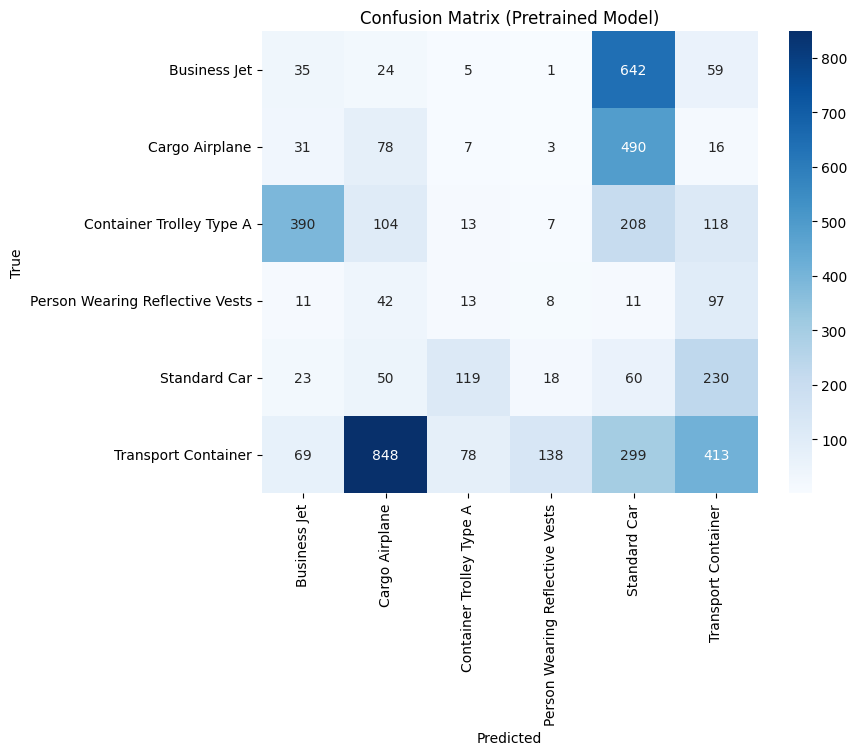

In [10]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import build_detection_test_loader, DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2 import model_zoo

# --- CONFIG ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  # your 6 classes
cfg.MODEL.MASK_ON = False
cfg.DATASETS.TEST = ("airport_val",)

predictor = DefaultPredictor(cfg)

# --- 1. Run COCO evaluator (mAP etc.) ---
evaluator = COCOEvaluator("airport_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "airport_val")

print("\n--- Evaluating Pretrained Model on Validation Set ---")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


# --- 2. IoU helper ---
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW, interH = max(0, xB - xA), max(0, yB - yA)
    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)


# --- 3. Collect predictions vs ground truth ---
dataset_dicts = DatasetCatalog.get("airport_val")  # ✅ fetch GT directly
y_true, y_pred = [], []

for d in dataset_dicts:
    # Load image as numpy
    img = plt.imread(d["file_name"])[:, :, :3]  # ensure RGB
    img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img  # normalize if needed
    img = img[:, :, ::-1]  # RGB -> BGR

    with torch.no_grad():
        outputs = predictor(img)

    # Ground truth
    gt_classes = [anno["category_id"] for anno in d["annotations"]]
    gt_boxes = [anno["bbox"] for anno in d["annotations"]]  # [x,y,w,h]
    gt_boxes = [[x, y, x+w, y+h] for x, y, w, h in gt_boxes]

    # Predictions
    instances = outputs["instances"].to("cpu")
    pred_classes = instances.pred_classes.numpy()
    pred_boxes = instances.pred_boxes.tensor.numpy()

    # Match predictions to GT using IoU
    matched_gt = set()
    for i, pbox in enumerate(pred_boxes):
        best_iou, best_gt = 0, -1
        for j, gbox in enumerate(gt_boxes):
            if j in matched_gt:
                continue
            iou = compute_iou(pbox, gbox)
            if iou > best_iou:
                best_iou, best_gt = iou, j
        if best_iou >= 0.5:  # IoU threshold
            y_true.append(gt_classes[best_gt])
            y_pred.append(pred_classes[i])
            matched_gt.add(best_gt)

# --- 4. Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

# --- 5. Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Pretrained Model)")
plt.show()


## After Finetuning

In [11]:
import os
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.model_zoo import model_zoo

# --- 1. Create a configuration object ---
cfg = get_cfg()

# --- 2. Load a pre-trained ViTDet configuration ---
# The ViTDet configs are not in the main model zoo, so we use a standard one and will modify it.
# We'll use a Mask R-CNN config as a base and set the backbone to ViT.
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# --- 3. Set custom parameters for your dataset and training ---
cfg.DATASETS.TRAIN = ("airport_train",)
cfg.DATASETS.TEST = ("airport_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# This points to the pre-trained COCO weights for the base model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Training parameters
cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size (reduce if you get memory errors)
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000 # Number of training iterations (increase for better results)
cfg.SOLVER.STEPS = [] # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# --- THE MOST IMPORTANT STEP: Set the number of classes ---
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
# Since we are not doing segmentation, we can disable the mask head
cfg.MODEL.MASK_ON = False

# --- 4. Start the Training ---
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False) # Start training from scratch (with pre-trained weights)

print("--- Starting Fine-Tuning ---")
trainer.train()
print("\nFine-tuning complete! ✅")

--- Starting Fine-Tuning ---


2025-09-03 11:08:10.873897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756897691.085523      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756897691.145348      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Fine-tuning complete! ✅


--- Step 1: Loading model configuration and fine-tuned weights ---
Successfully loaded model from: ./output/model_final.pth ✅

--- Step 2: Generating Learning and Loss Curves ---


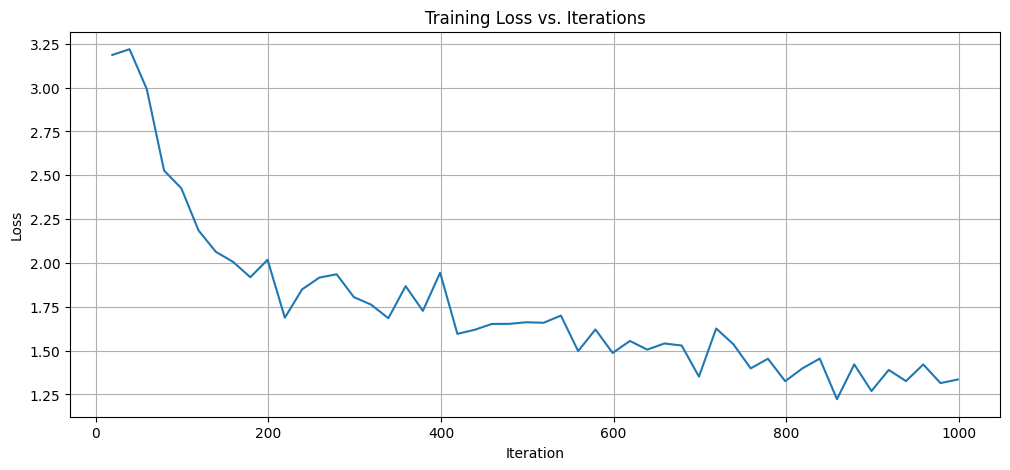

Saved learning curve to learning_curve.png

--- Step 3: Generating Classification Report (mAP) ---
Loading and preparing results...
DONE (t=0.45s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Recall     

Building Confusion Matrix:   0%|          | 0/1560 [00:00<?, ?it/s]

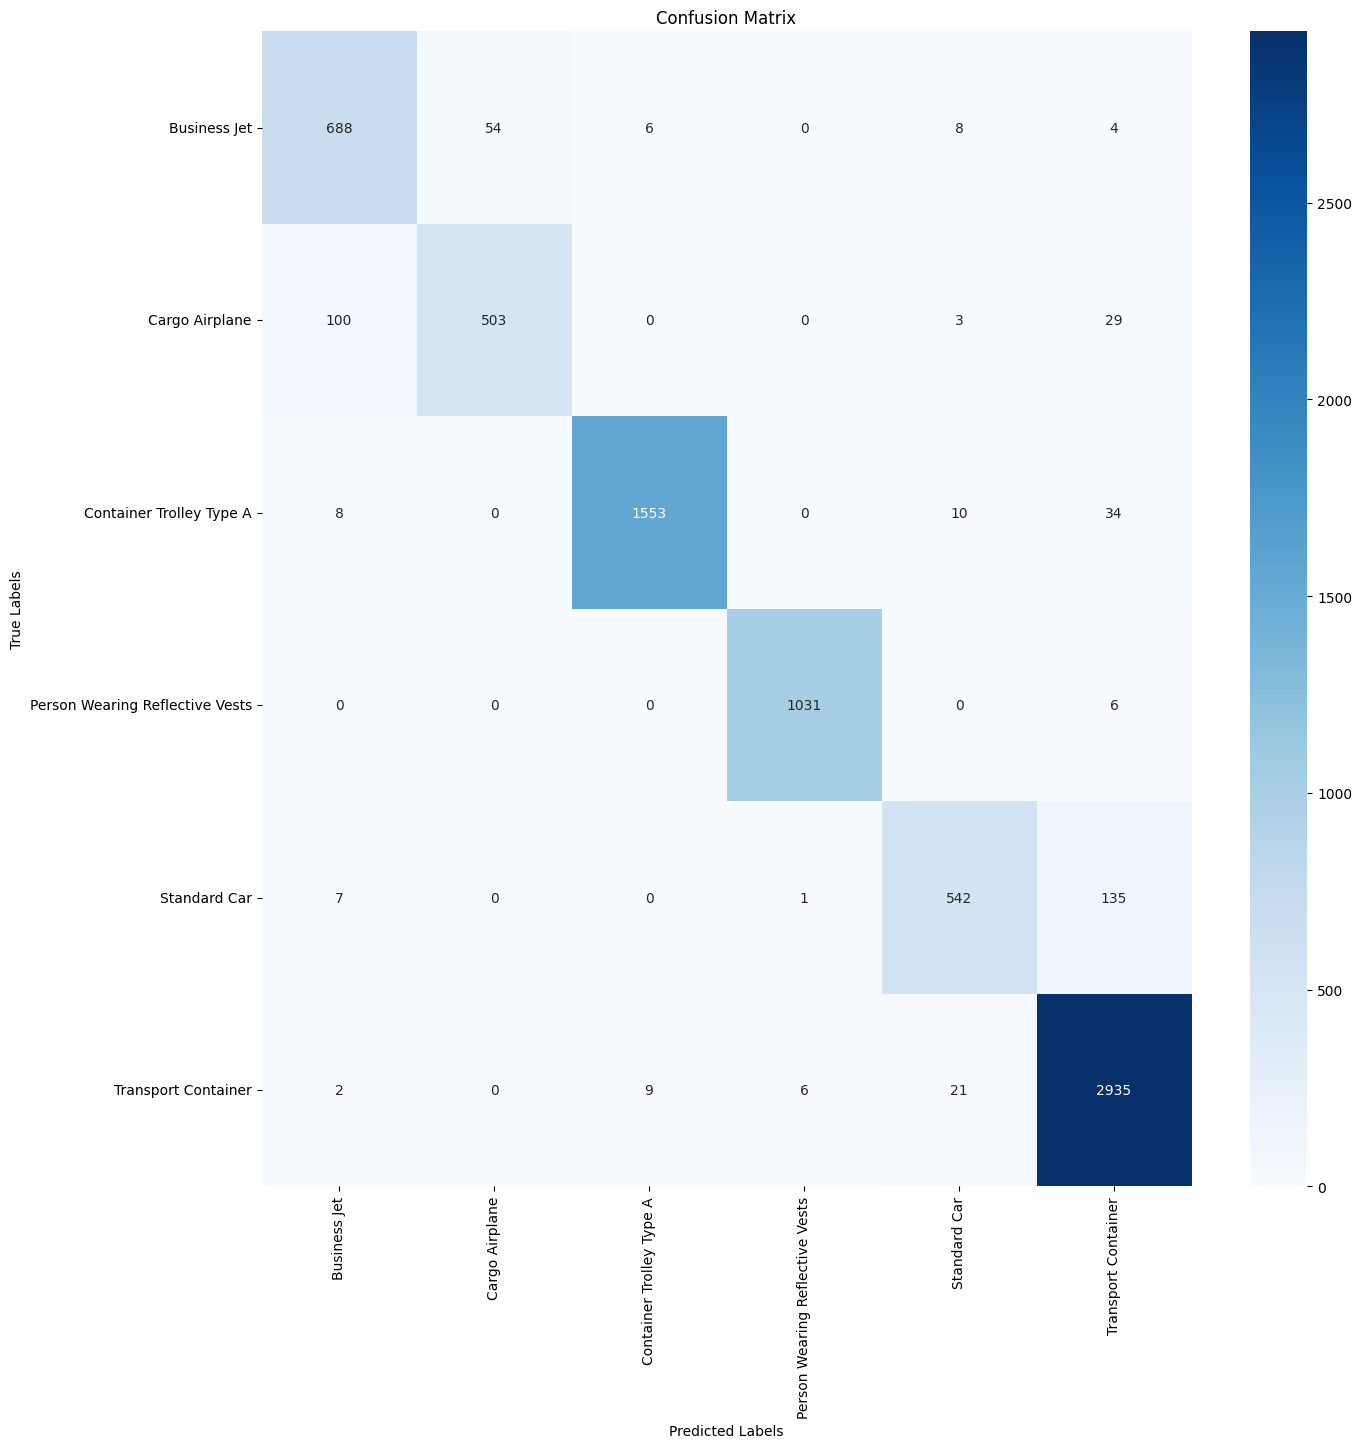

Saved confusion matrix to confusion_matrix.png

--- Step 5: Visualizing predictions on sample images ---

Predictions for: /kaggle/working/coco_airport_dataset/val/aut-0554-00003332.jpg


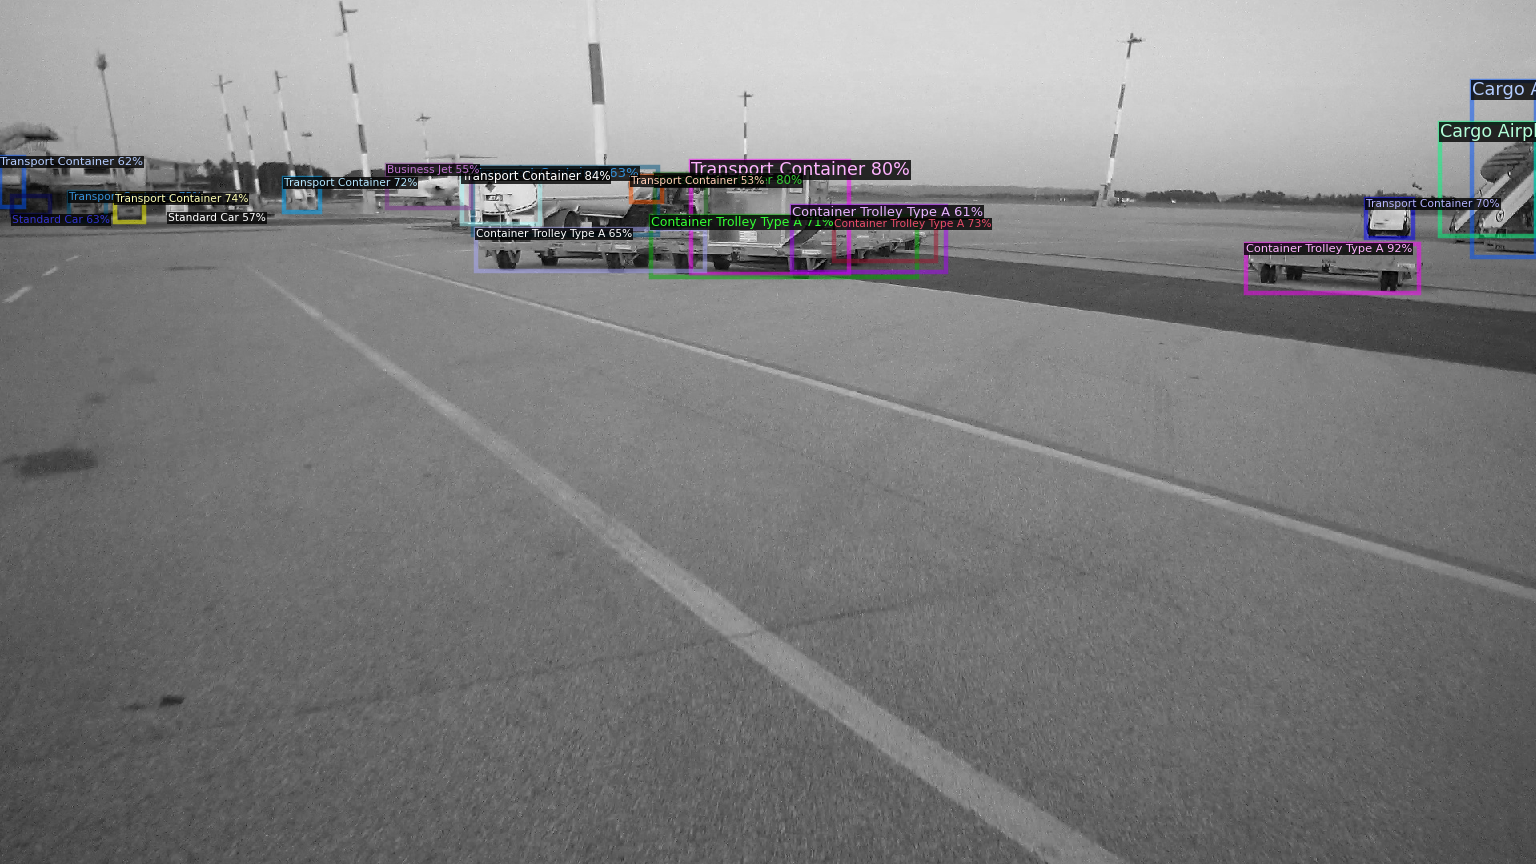


Predictions for: /kaggle/working/coco_airport_dataset/val/aut-1087-00007208.jpg


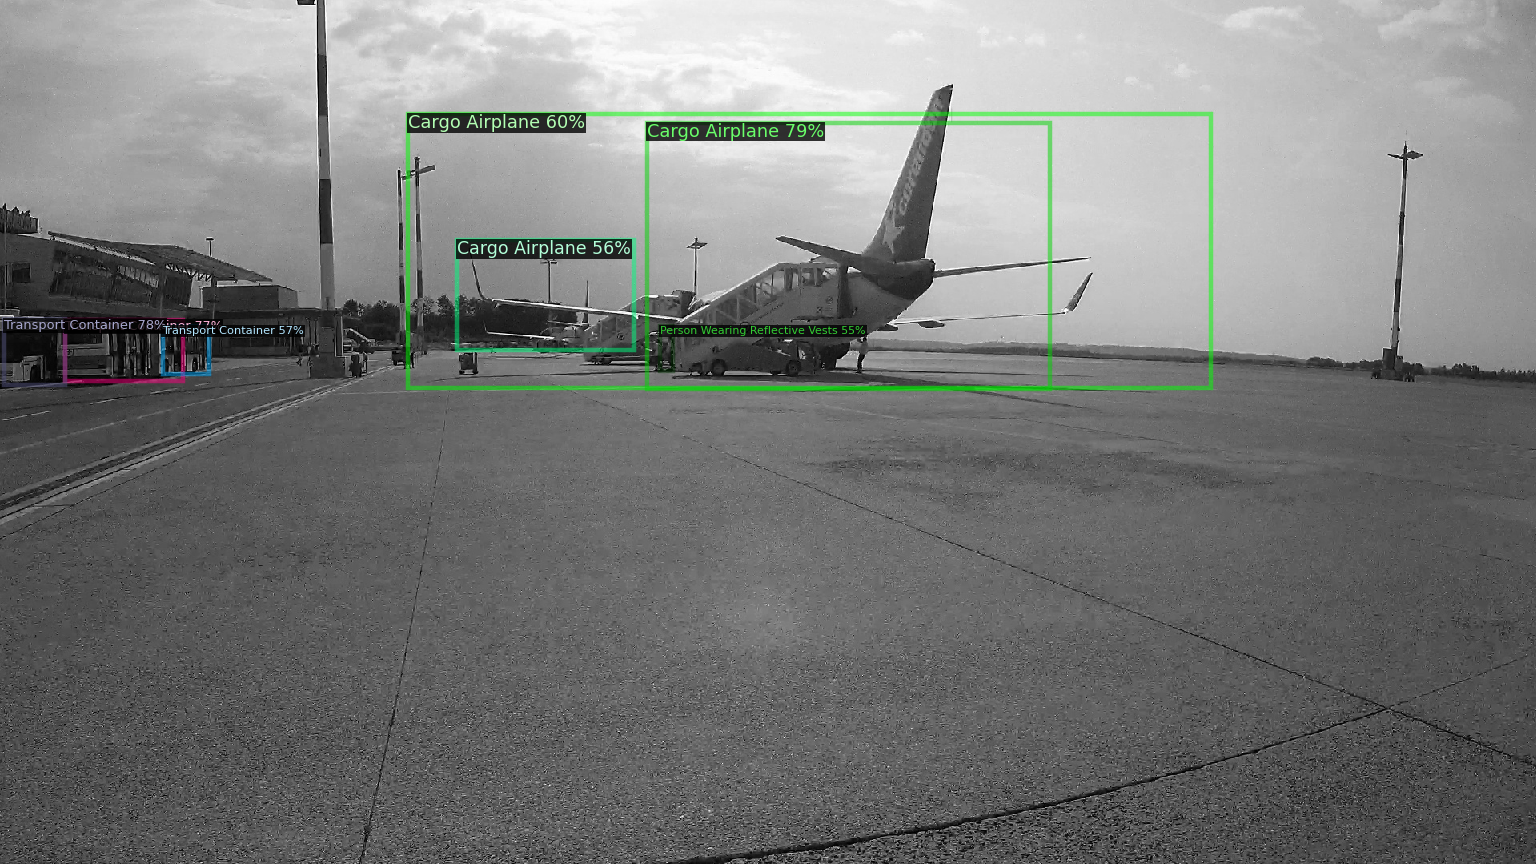


Predictions for: /kaggle/working/coco_airport_dataset/val/aut-0857-00002968.jpg


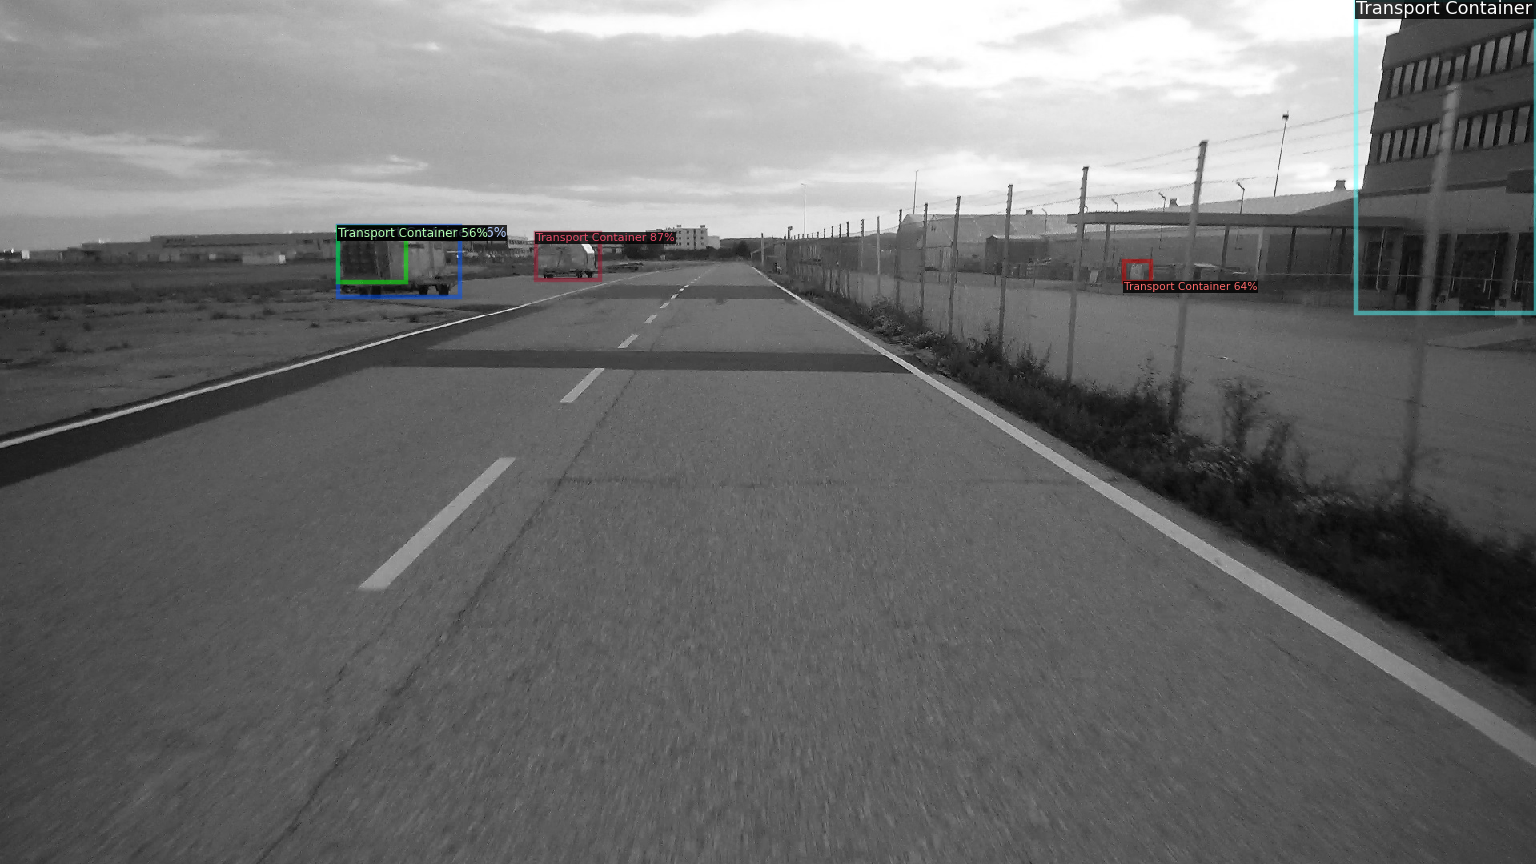

In [12]:
import os
import cv2
import random
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.build import build_detection_test_loader
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

# --- 1. Recreate the Configuration and Load the Trained Model ---
print("--- Step 1: Loading model configuration and fine-tuned weights ---")
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.MODEL.MASK_ON = False
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
print(f"Successfully loaded model from: {cfg.MODEL.WEIGHTS} ✅")


# --- 2. Generate Learning and Loss Curves ---
print("\n--- Step 2: Generating Learning and Loss Curves ---")
experiment_folder = cfg.OUTPUT_DIR
try:
    with open(os.path.join(experiment_folder, "metrics.json"), "r") as f:
        metrics = [json.loads(line) for line in f]
    
    plt.figure(figsize=(12, 5))
    plt.plot(
        [x["iteration"] for x in metrics if "total_loss" in x],
        [x["total_loss"] for x in metrics if "total_loss" in x],
    )
    plt.title("Training Loss vs. Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig('learning_curve.png')
    plt.show()
    print("Saved learning curve to learning_curve.png")
except FileNotFoundError:
    print("Could not find 'metrics.json'. Skipping loss curve generation.")


# --- 3. Generate Classification Report (mAP) ---
print("\n--- Step 3: Generating Classification Report (mAP) ---")
evaluator = COCOEvaluator("airport_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "airport_val")
results = inference_on_dataset(predictor.model, val_loader, evaluator)
print("\n--- COCO Evaluation Results ---")
print(results)
print("-----------------------------")


# --- 4. Generate and Display Confusion Matrix ---
print("\n--- Step 4: Generating Confusion Matrix ---")
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int32)
dataset_dicts = DatasetCatalog.get("airport_val")

for d in tqdm(dataset_dicts, desc="Building Confusion Matrix"):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    gt_boxes = [ann["bbox"] for ann in d["annotations"]]
    gt_classes = [ann["category_id"] for ann in d["annotations"]]
    
    pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()

    for i, gt_box_coco in enumerate(gt_boxes):
        gt_cls = gt_classes[i]
        # Convert COCO [x,y,w,h] to [x1,y1,x2,y2]
        gt_box = [gt_box_coco[0], gt_box_coco[1], gt_box_coco[0] + gt_box_coco[2], gt_box_coco[1] + gt_box_coco[3]]
        
        best_iou = 0
        matched_pred_cls = -1
        
        for j, pred_box in enumerate(pred_boxes):
            iou = calculate_iou(gt_box, pred_box)
            if iou > best_iou:
                best_iou = iou
                matched_pred_cls = pred_classes[j]
        
        if best_iou > 0.5: # Consider it a match if IoU is > 0.5
            confusion_matrix[gt_cls, matched_pred_cls] += 1

if np.sum(confusion_matrix) > 0:
    plt.figure(figsize=(15, 15))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xticks(rotation=90); plt.yticks(rotation=0)
    plt.xlabel('Predicted Labels'); plt.ylabel('True Labels'); plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    print("Saved confusion matrix to confusion_matrix.png")
else:
    print("Could not generate confusion matrix (no matches found).")


# --- 5. Visualize Predictions on Sample Images ---
print("\n--- Step 5: Visualizing predictions on sample images ---")
airport_metadata = MetadataCatalog.get("airport_val")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1], metadata=airport_metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    print(f"\nPredictions for: {d['file_name']}")
    cv2_imshow(out.get_image()[:, :, ::-1])